# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se traem al directorio $data_dir. 

Se utilizarán tablas de población para, en el futuro, obtener información más relevante

## Obtención de datos
Se obtienen los datos de población desde los repositorios de Naciones Unidas.

Los datos de contagios y fallecidos por COVID-19 se traen del repositorio mantenido por la Universidad Johns Hopkins

In [1]:
data_dir = './data'
covid_dir = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
covid_git_url = 'https://github.com/CSSEGISandData/COVID-19'
population_file = 'WPP2019_PopulationByAgeSex_Medium.csv'
covid_confirmed_file = 'time_series_covid19_confirmed_global.csv'
covid_deaths_file = 'time_series_covid19_deaths_global.csv'
un_pop_repo_url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/' + population_file

! if [ ! -d '{data_dir}' ]; then echo 'No existe directorio de datos. Creándolo...'; mkdir '{data_dir}' ; fi
! if [ ! -d '{data_dir}/{covid_dir}' ]; then echo 'No existe clone del repositorio {covid_dir}. Ejecutando git clone {covid_git_url}'; cd '{data_dir}';  git clone '{covid_git_url}'; fi
! if [ ! -f '{data_dir}/{population_file}' ]; then echo 'No existen datos de población Trayéndolos de {un_pop_repo_url}'; cd '{data_dir}'; curl -g '{un_pop_repo_url}' -o $population_file; fi

## Actualización de ficheros

In [2]:
! cd '{data_dir}/{covid_dir}'; git pull
! ls -l '{data_dir}/{covid_dir}/'

remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 172 (delta 108), reused 113 (delta 108), pack-reused 58
Receiving objects: 100% (172/172), 1.91 MiB | 1.06 MiB/s, done.
Resolving deltas: 100% (118/118), completed with 28 local objects.
From https://github.com/CSSEGISandData/COVID-19
   984016e29..7e12856eb  master          -> origin/master
 * [new branch]          Fix_NH_01122021 -> origin/Fix_NH_01122021
 * [new branch]          Fix_NH_011221   -> origin/Fix_NH_011221
   5ab5c32af..6202a3bb5  automated-patch-for-delayed-data-01-12-2021 -> origin/automated-patch-for-delayed-data-01-12-2021
 * [new branch]          patch-ca-deaths-20210113 -> origin/patch-ca-deaths-20210113
   a409e229e..8b60702fc  web-data        -> origin/web-data
Updating 984016e29..7e12856eb
Fast-forward
 .../csse_covid_19_daily_reports/01-12-2021.csv     | 7956 ++++++++++----------
 .../csse_covid_19_daily_reports_us

## Importación de datos
Lo primero es común a todos los programas que traten datos

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos y de casso confirmados

In [4]:
deaths = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_deaths_file, 
                      index_col=[0,1,2,3])
confirmed = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_confirmed_file, 
                           index_col=[0,1,2,3])
population = pd.read_csv (data_dir + '/' + population_file)

## Tratamiento de datos
Se filtran los datos de población para suprimir la división por edades y quedarnos con los del año 2021. 
Se conserva la división por género por si tuviese interés

In [5]:
pop_filtered = population[(population['VarID'] == 2) & (population['Time'] == 2021) ] \
                         [['Location','PopMale','PopFemale','PopTotal']] \
                         .groupby(['Location']).sum()

#population.head()
#pop_filtered.index.names

pop_filtered.loc['Spain']
pop_filtered

,PopMale,PopFemale,PopTotal
Location,,,
Afghanistan,20434.981,19400.447,39835.428
Africa,686414.950,687071.522,1373486.472
African Group,685518.459,686168.843,1371687.302
African Union,685838.061,686461.113,1372299.174
African Union: Central Africa,81613.324,81688.426,163301.750
...,...,...,...
World,3970238.390,3904727.342,7874965.732
World Bank Regional Groups (developing only),3337382.318,3266929.594,6604311.912
Yemen,15358.046,15132.593,30490.639


Se cambia el nombre de algunos índices

In [6]:
change_dict = {'United States of America': 'US'}


pop_index_list = pop_filtered.index.tolist()

for country in change_dict:
    pop_index_list[pop_index_list.index(country)] = change_dict[country]

pop_filtered.index = pop_index_list
pop_filtered.loc['US']

PopMale      164729.431
PopFemale    168185.643
PopTotal     332915.074
Name: US, dtype: float64

Se obtienen los dataframes de incrementos por población

In [7]:
deaths_sum = deaths.groupby(level=1).sum()
confirmed_sum = confirmed.groupby(level=1).sum()


def get_by_pop_inc_df (df,pop):
    df_by_pop_inc = df.divide(pop_filtered['PopTotal']/(pop/1000), axis=0).transpose().diff()
    df_by_pop_inc.index = pd.to_datetime(df_by_pop_inc.index)
    return df_by_pop_inc
    
confirmed_sum_by_pop_inc = get_by_pop_inc_df(confirmed_sum,100000)
deaths_sum_by_pop_inc = get_by_pop_inc_df(deaths_sum,1000000)



confirmed_sum_by_pop_inc['Spain']

2020-01-22           NaN
2020-01-23      0.000000
2020-01-24      0.000000
2020-01-25      0.000000
2020-01-26      0.000000
                 ...    
2021-01-08     54.456915
2021-01-09      0.000000
2021-01-10      0.000000
2021-01-11    131.397417
2021-01-12     54.418409
Name: Spain, Length: 357, dtype: float64

## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados utilizando ventanas deslizantes de 15 días en el caso de casos confirmados (es estándar) y de 7 días en el caso de fallecimientosya que se ha comprobado
que los datos presentan fuerte correlación con el día de la semana. De esta forma se evitan dientes de sierra. 

Los países para los cuales se desean los gráficos están en el array interesting_countries.

El último dato es el de la fecha en la que se ejecuta el notebook (todate = today). El primero de los datos es el de hace nweeks (configurable) semanas.

La escala en y puede ser logarítimca (logaritmic = True) o no (logaritmic = False)

<AxesSubplot:title={'center':'Fallecimientos en últimos 7 días por millón de habitantes'}>

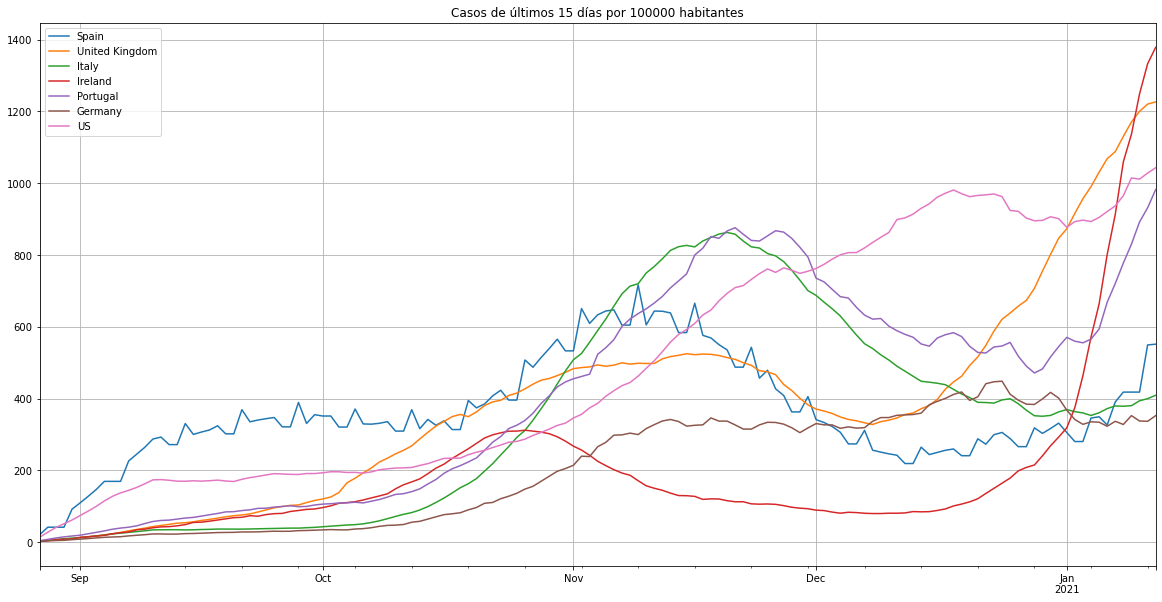

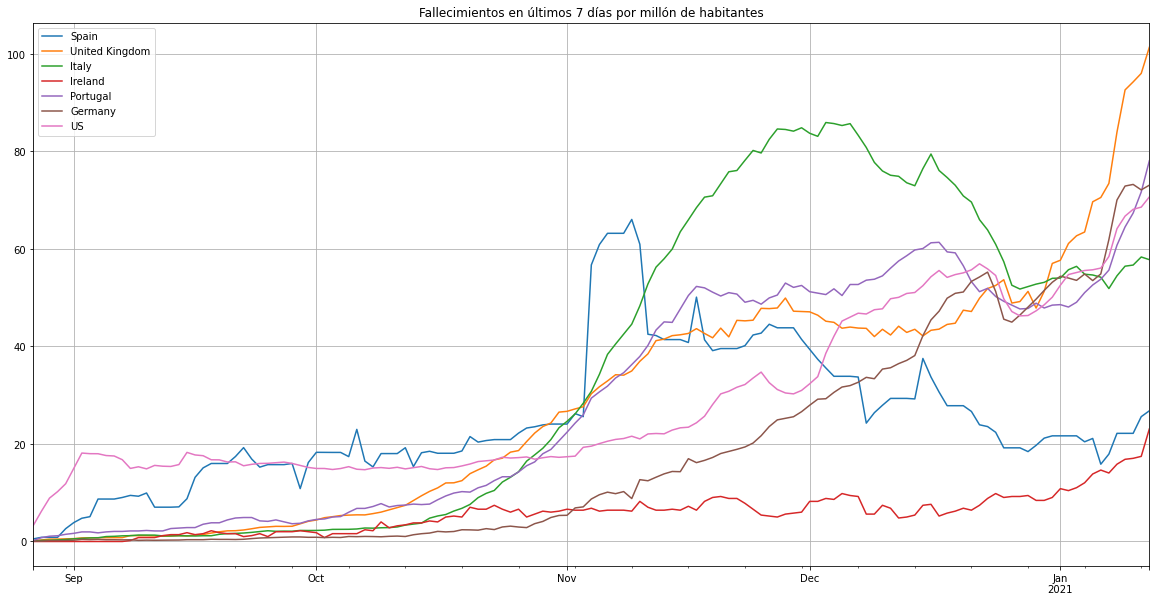

In [12]:
import datetime

nweeks=20
interesting_countries = ['Spain','United Kingdom', 'Italy' , 'Ireland', 'Portugal', 'Germany', 'US' ]

today = datetime.date.today()
#yesterday = today - datetime.timedelta(days=1)
fromdate=today - datetime.timedelta(weeks=nweeks)
todate=today
fsize=(20,10)
logaritmic = False

confirmed_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=15).sum()[interesting_countries].plot(title='Casos de últimos 15 días por 100000 habitantes', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True
                                                                        )
deaths_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=7).sum()[interesting_countries].plot(title='Fallecimientos en últimos 7 días por millón de habitantes', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True
                                                                        )